In [ ]:
# Day 3 — JupyterLab: PK exploratory analysis
- Load dataset, plot linear & semi-log curves, compute AUC, estimate k and t1/2.
- File: example_pk_data.csv
- Output figures saved in `figures/`


In [3]:
# — environment & imports
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Python executable:", sys.executable if 'sys' in globals() else "sys not imported")
print("Current working directory:", os.getcwd())


Python executable: sys not imported
Current working directory: /home/pramood/pk-project


In [9]:
csv_path = "example_pk_data.csv"   
print("CSV exists:", os.path.exists(csv_path))
df = pd.read_csv(csv_path)
df.head()



CSV exists: True


,SubjectID,Dose_mg,Route,Time_hr,Conc_ng_per_mL,Age_yrs,Weight_kg
0,1,100,IV,0.25,150,35,70
1,1,100,IV,0.50,130,35,70
2,1,100,IV,1.00,110,35,70
3,1,100,IV,2.00,90,35,70
4,1,100,IV,4.00,60,35,70


In [10]:
print("Columns:", list(df.columns))

# adapt to your file's column names — adjust if names differ
# this CSV uses: Time_hr, Conc_ng_per_mL, SubjectID
df = df.rename(columns=lambda s: s.strip())  # trim whitespace if any

# create consistent columns
time_col = "Time_hr"
conc_col = "Conc_ng_per_mL"
subject_col = "SubjectID"

# convert conc -> mg/L (ng/mL -> mg/L)
df["conc_mg_per_L"] = df[conc_col] / 1000.0

# sort for safety
df = df.sort_values([subject_col, time_col])
df.head()


Columns: ['SubjectID', 'Dose_mg', 'Route', 'Time_hr', 'Conc_ng_per_mL', 'Age_yrs', 'Weight_kg']


,SubjectID,Dose_mg,Route,Time_hr,Conc_ng_per_mL,Age_yrs,Weight_kg,conc_mg_per_L
0,1,100,IV,0.25,150,35,70,0.15
1,1,100,IV,0.50,130,35,70,0.13
2,1,100,IV,1.00,110,35,70,0.11
3,1,100,IV,2.00,90,35,70,0.09
4,1,100,IV,4.00,60,35,70,0.06


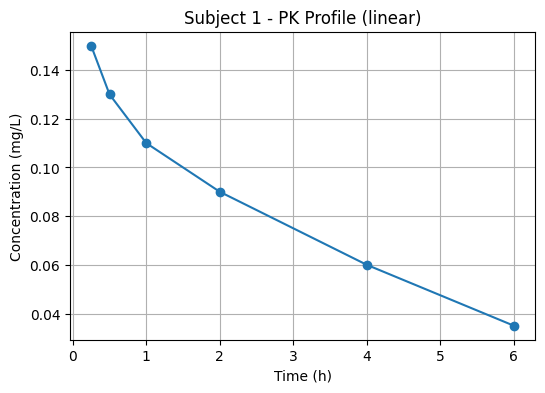

Saved: figures/pk_subject1_linear.png


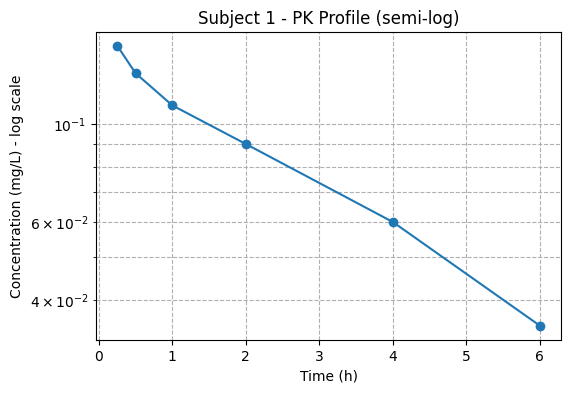

Saved: figures/pk_subject1_semilog.png


In [11]:
# select subject
subject_id = 1         # change if you want other subject
df_sub = df[df[subject_col] == subject_id].copy()
df_sub = df_sub.sort_values(time_col)

# create figures folder
fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)

# linear plot
save_linear = os.path.join(fig_dir, f"pk_subject{subject_id}_linear.png")
plt.figure(figsize=(6,4))
plt.plot(df_sub[time_col], df_sub["conc_mg_per_L"], 'o-', linewidth=1.5)
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.title(f"Subject {subject_id} - PK Profile (linear)")
plt.grid(True)
plt.savefig(save_linear, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print("Saved:", save_linear)

# semi-log plot
save_semi = os.path.join(fig_dir, f"pk_subject{subject_id}_semilog.png")
plt.figure(figsize=(6,4))
plt.semilogy(df_sub[time_col], df_sub["conc_mg_per_L"], 'o-', linewidth=1.5)
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L) - log scale")
plt.title(f"Subject {subject_id} - PK Profile (semi-log)")
plt.grid(True, which='both', ls='--')
plt.savefig(save_semi, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print("Saved:", save_semi)


In [13]:
# compute AUC (0 -last observed time) using trapezoidal rule
t=df_sub[time_col].values
c=df_sub["conc_mg_per_L"].values
auc=np.trapezoid(c,t)
print(f"Subject {subject_id} AUC (0-last) ={auc:.6f} mg h/L")

Subject 1 AUC (0-last) =0.440000 mg h/L


In [18]:
# choose elimination phase points (adjust threshold if needed)
elim_threshold=1.0 #hours - change if your data suggests different
elim_mask=df_sub[time_col]>=elim_threshold

t_elim=df_sub.loc[elim_mask, time_col].values
c_elim=df_sub.loc[elim_mask, "conc_mg_per_L"].values

#safety: need at least 2 points
if len (t_elim) < 2:
    print("Not enough elimination-phase points - choose lower threshold or inspect data.")
else:
    lnC=np.log(c_elim)
    slope,intercept =np.polyfit(t_elim,lnC,1)
    k_est=-slope
    t_half=np.log(2)/k_est if k_est>0 else np.nan
    print(f"Estimated k={k_est :.6f}1/h")
    print(f"Estimated t1/2={t_half:.3f}h")

Estimated k=0.2273141/h
Estimated t1/2=3.049h


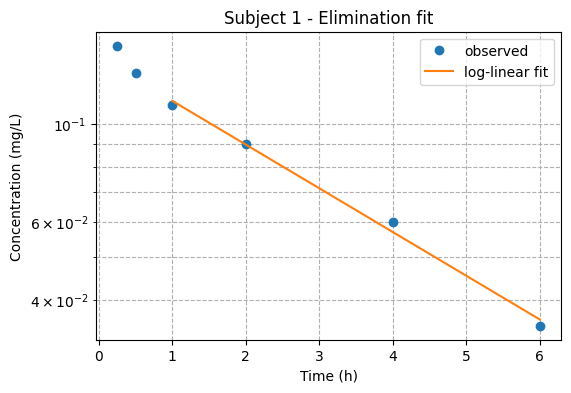

In [19]:
if len(t_elim) >= 2:
    t_fit = np.linspace(t_elim.min(), t_elim.max(), 100)
    c_fit = np.exp(intercept + slope * t_fit)

    plt.figure(figsize=(6,4))
    plt.semilogy(df_sub[time_col], df_sub["conc_mg_per_L"], 'o', label='observed')
    plt.semilogy(t_fit, c_fit, '-', label='log-linear fit')
    plt.xlabel("Time (h)")
    plt.ylabel("Concentration (mg/L)")
    plt.title(f"Subject {subject_id} - Elimination fit")
    plt.legend()
    plt.grid(True, which='both', ls='--')
    plt.show()


In [21]:
subjects = sorted(df[subject_col].unique())
summary = []

for s in subjects:
    df_s = df[df[subject_col]==s].sort_values(time_col)
    t = df_s[time_col].values
    c = df_s["conc_mg_per_L"].values
    auc_s = np.trapezoid(c, t)
    
    # elimination fit - choose threshold adaptively (e.g., > median time/3)
    
    mask = t >= np.median(t)/2.0
    t_el = t[mask]
    c_el = c[mask]
    if len(t_el) >= 2 and np.all(c_el>0):
        slope, intercept = np.polyfit(t_el, np.log(c_el), 1)
        k_s = -slope
        t_half_s = np.log(2)/k_s if k_s>0 else np.nan
    else:
        k_s = np.nan
        t_half_s = np.nan
    summary.append({"Subject": s, "AUC_mg_h_L": auc_s, "k_1_per_h": k_s, "t1_2_h": t_half_s})

summary_df = pd.DataFrame(summary)
summary_df


,Subject,AUC_mg_h_L,k_1_per_h,t1_2_h
0,1,0.44000,0.227314,3.049298
1,2,0.47125,0.209711,3.305253
2,3,0.41125,0.248538,2.788901


In [22]:
summary_df.to_csv(os.path.join(fig_dir, "pk_summary_table.csv"), index=False)
print("Saved summary to", os.path.join(fig_dir, "pk_summary_table.csv"))


Saved summary to figures/pk_summary_table.csv


In [26]:
!pwd
!ls -la
!git status




/home/pramood/pk-project
total 176
drwxrwxr-x  6 pramood pramood   4096 Sep 20 10:36  .
drwxr-x--- 48 pramood pramood   4096 Sep 19 20:25  ..
-rw-rw-r--  1 pramood pramood    455 Sep 19 20:39  analyze_pk.py
drwxrwxr-x  3 pramood pramood   4096 Sep 20 09:47  data
-rw-rw-r--  1 pramood pramood 140007 Sep 20 10:36 'Day 3_Analysis.ipynb'
-rw-rw-r--  1 pramood pramood    449 Sep 19 20:13  example_pk_data.csv
drwxrwxr-x  2 pramood pramood   4096 Sep 20 10:18  figures
drwxrwxr-x  8 pramood pramood   4096 Sep 19 20:40  .git
drwxrwxr-x  2 pramood pramood   4096 Sep 20 09:47  .ipynb_checkpoints
-rw-rw-r--  1 pramood pramood     21 Sep 19 19:49  README.md
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    data/example_pk_data.csv

Untracked files:
  (use "

In [27]:
!pwd
!ls -la *.ipynb


/home/pramood/pk-project
-rw-rw-r-- 1 pramood pramood 140007 Sep 20 10:36 'Day 3_Analysis.ipynb'


In [28]:
!git status


On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    data/example_pk_data.csv

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	Day 3_Analysis.ipynb
	example_pk_data.csv
	figures/

no changes added to commit (use "git add" and/or "git commit -a")


In [30]:
# show repo status and files (notebook cell)
!pwd
!ls -la
!git status --porcelain
!ls -la day3_analysis.ipynb || echo "no day3_analysis.ipynb"
!ls -la figures || echo "no figures folder"



/home/pramood/pk-project
total 176
drwxrwxr-x  6 pramood pramood   4096 Sep 20 10:38  .
drwxr-x--- 48 pramood pramood   4096 Sep 19 20:25  ..
-rw-rw-r--  1 pramood pramood    455 Sep 19 20:39  analyze_pk.py
drwxrwxr-x  3 pramood pramood   4096 Sep 20 09:47  data
-rw-rw-r--  1 pramood pramood 143021 Sep 20 10:38 'Day 3_Analysis.ipynb'
-rw-rw-r--  1 pramood pramood    449 Sep 19 20:13  example_pk_data.csv
drwxrwxr-x  2 pramood pramood   4096 Sep 20 10:18  figures
drwxrwxr-x  8 pramood pramood   4096 Sep 20 10:38  .git
drwxrwxr-x  2 pramood pramood   4096 Sep 20 09:47  .ipynb_checkpoints
-rw-rw-r--  1 pramood pramood     21 Sep 19 19:49  README.md
 D data/example_pk_data.csv
?? .ipynb_checkpoints/
?? "Day 3_Analysis.ipynb"
?? example_pk_data.csv
?? figures/
ls: cannot access 'day3_analysis.ipynb': No such file or directory
no day3_analysis.ipynb
total 104
drwxrwxr-x 2 pramood pramood  4096 Sep 20 10:18 .
drwxrwxr-x 6 pramood pramood  4096 Sep 20 10:38 ..
-rw-rw-r-- 1 pramood pramood 41498

In [33]:
!git add Day3_Analysis.ipynb
!git add figures/*.png 2>/dev/null || true
!git add figures/pk_summary_table.csv 2>/dev/null || true
!git status --porcelain


fatal: pathspec 'Day3_Analysis.ipynb' did not match any files
 D data/example_pk_data.csv
A  figures/pk_subject1_linear.png
A  figures/pk_subject1_semilog.png
A  figures/pk_summary_table.csv
?? .ipynb_checkpoints/
?? "Day 3_Analysis.ipynb"
?? example_pk_data.csv


In [36]:
mv "Day3_Analysis.ipynb" day3_analysis.ipynb
# confirm
ls -la Day3_Analysis.ipynb


SyntaxError: invalid syntax (2796326247.py, line 1)